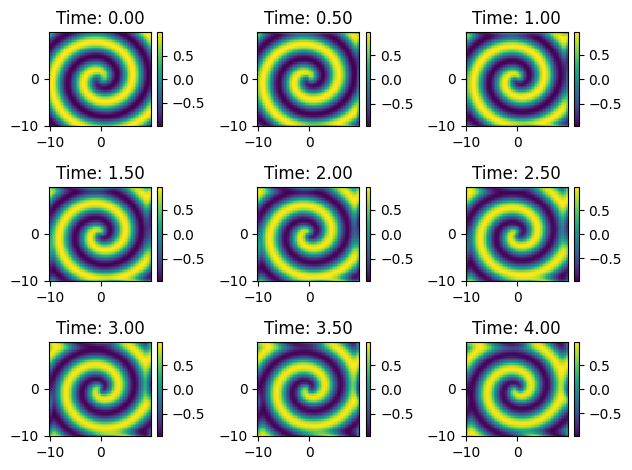

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Initializing Parameters
tspan = np.arange(0, 4.5, 0.5) 
beta = 1
D1 = D2 = 0.1
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

# Defining the spatial domain
x2 = np.linspace(-Lx / 2, Lx / 2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly / 2, Ly / 2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

#  Initial Conditons
m = 1 # Number of spirals
U0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))
V0 = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(m * np.angle(X + 1j * Y) - np.sqrt(X**2 + Y**2))

# Define spectral k values
kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx / 2), np.arange(-nx / 2, 0)))
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny / 2), np.arange(-ny / 2, 0)))
kx[0] = ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

def rhs(t, UVt, nx, ny, N, K, D1, D2, beta):
    # Split U and V
    Ut = UVt[:N].reshape((nx,ny))
    Vt = UVt[N:].reshape((nx,ny))
    
    U = np.real(ifft2(Ut))
    V = np.real(ifft2(Vt))

    A_squared = U**2 + V**2
    lambda_A = 1 - A_squared
    omega_A = -beta * A_squared

    rhs_U = fft2(lambda_A * U - omega_A * V) - D1 * K * Ut
    rhs_V = fft2(omega_A * U + lambda_A * V) - D2 * K * Vt

    return np.hstack([rhs_U.ravel(), rhs_V.ravel()])

U0t = fft2(U0)
V0t = fft2(V0)
UV0t = np.hstack([U0t.ravel(), V0t.ravel()])

sol = solve_ivp(rhs, [tspan[0], tspan[-1]], UV0t, t_eval=tspan, args=(nx, ny, N, K, D1, D2, beta))

for i, t in enumerate(tspan):
    U_hat, V_hat = sol.y[:nx * ny, i].reshape((nx, ny)), sol.y[nx * ny:, i].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    plt.subplot(3, 3, i + 1)
    plt.pcolor(x, y, U, shading='auto')
    plt.title(f'Time: {t:.2f}')
    plt.colorbar()
plt.tight_layout()
plt.show()

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.pcolor(x, y, np.zeros((nx, ny)), shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax)
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, color='white', fontsize=12)

# Define the update function for the animation
def update(frame):
    # Extract U_hat and compute U for the current frame
    U_hat = sol.y[:nx * ny, frame].reshape((nx, ny)) + 1j * sol.y[nx * ny:2 * nx * ny, frame].reshape((nx, ny))
    U = np.real(ifft2(U_hat))
    
    # Update the plot and time text
    c.set_array(U.ravel())
    time_text.set_text(f'Time: {tspan[frame]:.2f}')
    return c, time_text

# Create the animation
ani = FuncAnimation(fig, update, frames=len(tspan), interval=100, blit=False)

# Display the animation in the notebook
plt.close(fig)
HTML(ani.to_jshtml())